# Setup

In this notebook we create a model of bug prediction for each minor version of Hive.

In [1]:
# imports
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
# constants
INPUT_DIR = "../../data/input/"
OUTPUT_DIR = "../../data/output/"
FONT_SCALE = 1.3
RELEASED_MINOR_VERSIONS = ["2.0.0", "2.1.0", "2.2.0", "2.3.0", "3.0.0", "3.1.0"]

# configurations
sns.set(font_scale=FONT_SCALE)

# Load data

In [3]:
df = pd.read_csv(OUTPUT_DIR + "raw_dataset.csv")
df

,AvgCyclomatic,AvgEssential,AvgLine,CountDeclClass,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclFunction,CountDeclInstanceMethodRatio,CountDeclMethod,CountDeclMethodDefaultRatio,...,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug,File,Version
0,1.0,1.0,9.0,1.0,0.0,9.0,17.0,1.000000,17.0,0.176471,...,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0
1,2.0,1.0,8.0,2.0,0.0,0.0,21.0,1.000000,21.0,0.000000,...,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0
2,2.0,1.0,14.0,1.0,0.0,2.0,21.0,1.000000,21.0,0.000000,...,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0
3,2.0,1.0,29.0,1.0,0.0,17.0,8.0,1.000000,8.0,0.125000,...,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0
4,2.0,1.0,17.0,1.0,0.0,0.0,6.0,1.000000,6.0,0.000000,...,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0,accumulo-handler/src/java/org/apache/hadoop/hi...,2.0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75245,2.0,1.0,11.0,1.0,2.0,1.0,77.0,0.974026,77.0,0.000000,...,0.0,2.0,79.0,9.389610,3.389610,2.168831,2.0,0,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3
75246,1.0,1.0,6.0,1.0,1.0,0.0,21.0,0.952381,21.0,0.000000,...,0.0,1.0,71.0,2.523810,2.666667,1.190476,1.0,0,storage-api/src/java/org/apache/hadoop/hive/se...,3.1.3
75247,1.0,1.0,7.0,2.0,3.0,1.0,38.0,0.842105,38.0,0.078947,...,0.5,1.0,43.0,7.026316,2.421053,1.815789,2.0,0,storage-api/src/java/org/apache/hive/common/ut...,3.1.3
75248,1.0,1.0,4.0,2.0,3.0,2.0,7.0,0.142857,7.0,0.000000,...,0.0,1.0,0.0,2.142857,2.000000,1.285714,2.0,0,storage-api/src/java/org/apache/hive/common/ut...,3.1.3


### Clean data
Let's drop too correlated variables detected in [analysis.ipynb](analysis.ipynb)

In [4]:
df.drop(columns=['CountDeclClass', 'CountStmt', 'SumCyclomatic', 'SumEssential', 'CountDeclFunction', 'CountDeclMethod', 
              'CountDeclMethodDefaultRatio', 'CountLineCodeExeRatio', 'CountSemicolonRatio', 'CountStmtDeclRatio',
              'CountStmtExeRatio', 'CountLineCodeRatio', 'CountLineCommentRatio', 'AvgLine'], inplace=True)

Let's check the result using dissimilarity dendogram

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

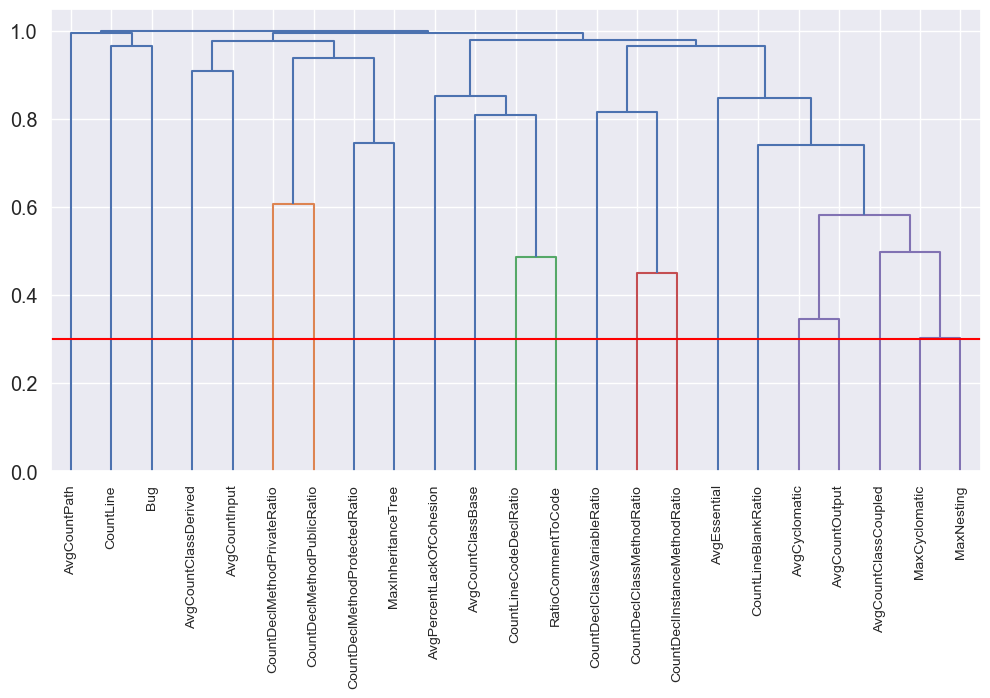

In [6]:
df_tmp = df.drop(columns=["File", "Version"])
dissimilarity = 1 - abs(df_tmp.corr())
Z = linkage(squareform(dissimilarity), method="complete")

plt.figure(figsize=(12, 6))
dendrogram(Z, labels=df_tmp.columns, orientation="top", leaf_rotation=90)
plt.axhline(y = .3, c="red")

# Models

In [7]:
# Utilities functions

"""Utilities functions."""


def results_headers(): 
  """Returns empty dataframe with correct headers."""
  return pd.DataFrame(columns=['Model', 'ROC-AUC', 'Precision', 'Recall', 'TT (sec)'])


def fit(model, name: str, append_to:pd.DataFrame=results_headers(), X_train=None, y_train=None, X_test=None, y_test=None, plot:bool=True):
  """Fit, evaluate model, and store the results.
  Plot confusion matrix and ROC Curve.
  
  Params
  ======
    model (Any): Sklearn model object.
    name (str): Model name for results.
    append_to (pd.DataFrame): Dataframe to which append the results.
    plot (bool): Plot cm and roc curve if True. Nothing if False.
  """
  # fit and predict model (with timer)
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  timer = time.time() - start_time

  # get scores
  scores = get_scores(y_test, y_pred)

  if plot is True:
    # plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    print("\n")

    # ROC curve and score
    pos_probs = model.predict_proba(X_test)[:,1]
    plot_roc_curve(y_test, pos_probs, scores['ROC-AUC'], name)
    print("\n")

  # store results
  scores = get_scores(y_test, y_pred)
  scores['Model'] = name
  scores['TT (sec)'] = round(timer, 4)
  return append_to.append(scores, ignore_index=True)


def get_scores(y_test, y_pred):
  """Returns a single model scores."""
  return {
    'Model': 'undefined',
    'ROC-AUC': round(metrics.roc_auc_score(y_test, y_pred), 4),
    'Precision': round(metrics.precision_score(y_test, y_pred), 4),
    'Recall': round(metrics.recall_score(y_test, y_pred), 4),
    'TT (sec)': 'NaN'
  }

def plot_confusion_matrix(y_test, y_pred):
  cm = metrics.confusion_matrix(y_test, y_pred)
  # labels components
  titles_ = ['TN', 'FP', 'FN', 'TP']
  counts_ = ["{0:0.0f}".format(val) for val in cm.flatten()]
  pcts_ = ["{0:.0%}".format(val) for val in cm.flatten()/np.sum(cm)]
  # build labels
  labels = [f"{v1}\n{v2}  ({v3})" for v1, v2, v3 in zip(titles_, counts_, pcts_)]
  labels = np.asarray(labels).reshape(2, 2)
  # classes names
  categories = ['0', '1']
  # plot
  fig, ax = plt.subplots(figsize=(8, 6))
  fig.patch.set_facecolor('white')
  sns.set(font_scale=1.5)
  sns.heatmap(pd.DataFrame(cm), annot=labels, cmap="rocket", fmt='', xticklabels=categories, yticklabels=categories)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  ax.xaxis.set_label_position("top")
  plt.show()
  sns.set(font_scale=FONT_SCALE)


def plot_roc_curve(y_test, pos_probs, roc_auc, title):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs)
  # plot
  plt.figure(figsize=(8, 6))
  plt.subplot()
  plt.plot([0, 1], [0, 1], 'k--', label='No skill classifier')
  plt.plot(fpr, tpr, marker='.', label=title)
  plt.xlabel('FP Rate')
  plt.ylabel('TP Rate')
  plt.title(f'{title} - ROC curve')
  plt.annotate(f'AUC = {round(roc_auc, 5)}', xy=(0.7, 0.5), fontsize=12,)
  plt.legend()    
  plt.show()


def plot_feature_importances(model, name, lr=False, features=None):
  """Show model features importance."""
  feature_importances = pd.DataFrame(columns = ['features', 'weight'])
  feature_importances['features'] = features
  feature_importances['weight'] = (
      model.coef_.reshape(len(feature_importances)) if lr else 
      model.feature_importances_
  )
  feature_importances = feature_importances.sort_values(['weight'], ascending=False)
  # plot
  fig = plt.figure(figsize=(6, 8))
  fig.patch.set_facecolor('white')
  sns.barplot(x='weight', y='features', data=feature_importances, palette="Spectral")
  plt.title(name + ' - Features importance', fontsize = 15)
  plt.show()


def save_model(model, filename):
  """Save a model as pickle."""
  joblib.dump(model, OUTPUT_DIR + f'/models/{filename}.pkl')


def load_model(filename):
  """Load model with name."""
  return joblib.load(OUTPUT_DIR + f'/models/{filename}.pkl')


def create_model():
    return make_pipeline(
        RandomUnderSampler(random_state=1, replacement=True),
        RandomForestClassifier(random_state=1, n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_depth=10, bootstrap=False)
    )

In [8]:
results = results_headers()

In [9]:

# train models for each version and save it

for version in RELEASED_MINOR_VERSIONS:
    data = df[df["Version"] == version].drop(columns=["File", "Version"])
    X_x = data.drop(columns=["Bug"])
    y = data["Bug"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X_x, y, test_size=.2, random_state=1)

    print(f"======================{version}=====================")

    model_ = create_model()
    results = fit(model_, f"{version}", results, X_train, y_train, X_test, y_test, False)
    save_model(model_, f"{version}")

======================2.0.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.1.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.2.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================2.3.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================3.0.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


======================3.1.0=====================


/tmp/ipykernel_138916/2442349808.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return append_to.append(scores, ignore_index=True)


In [10]:
results

,Model,ROC-AUC,Precision,Recall,TT (sec)
0,2.0.0,0.7865,0.0275,0.8571,1.1608
1,2.1.0,0.8650,0.2395,0.9091,1.9765
2,2.2.0,0.7630,0.1273,0.7241,1.4293
3,2.3.0,0.8872,0.0174,1.0000,0.9558
4,3.0.0,0.7931,0.0920,0.8000,1.4266
5,3.1.0,0.7396,0.0714,0.7619,1.4599


Let us plot performances evolution

### Metrics evolution

<AxesSubplot:xlabel='Model', ylabel='value'>

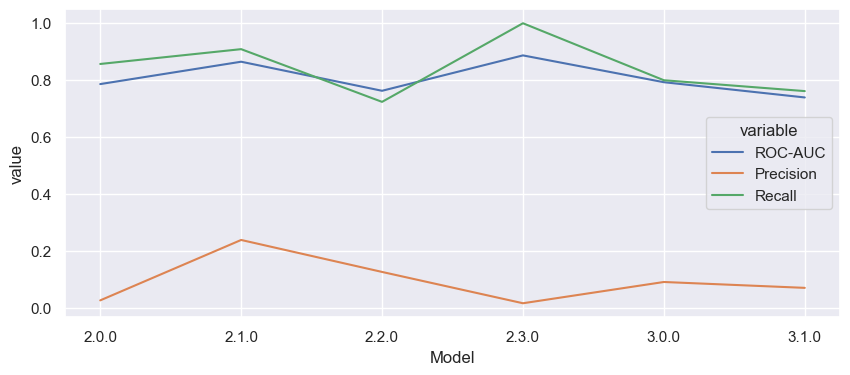

In [11]:
plt.figure(figsize=(10, 4))
sns.set(font_scale=1)

sns.lineplot(x='Model', y='value', hue='variable', 
             data=pd.melt(results.drop(columns=['TT (sec)']), ['Model']))

The models' performances vary from a version to another. The most remarkable versions models are 2.3.0 where the model has at the same time the highests AUC and Recall but the lowest precision, and the 2.1.0 which has the best precision and really good AUC and Recall.

We can also note that all the performances degraded from 2.1.0 to 2.2.0 (to 2.3.0 for the Precision) and from 3.0.0 to 3.1.0

On the other hand, there were improvements from 2.0.0 to 2.1.0

Finally, while Recall and AUC are overall high (more than 0.7), Precision is really low for all the models (less than 0.3) suggesting that all models on that dataset generally commit the FP error (i.e. predict there is a bug while there isn't)

### Features importances comparison

In [12]:
model_2_0_0 = load_model("2.0.0")
model_3_0_0 = load_model("3.0.0")

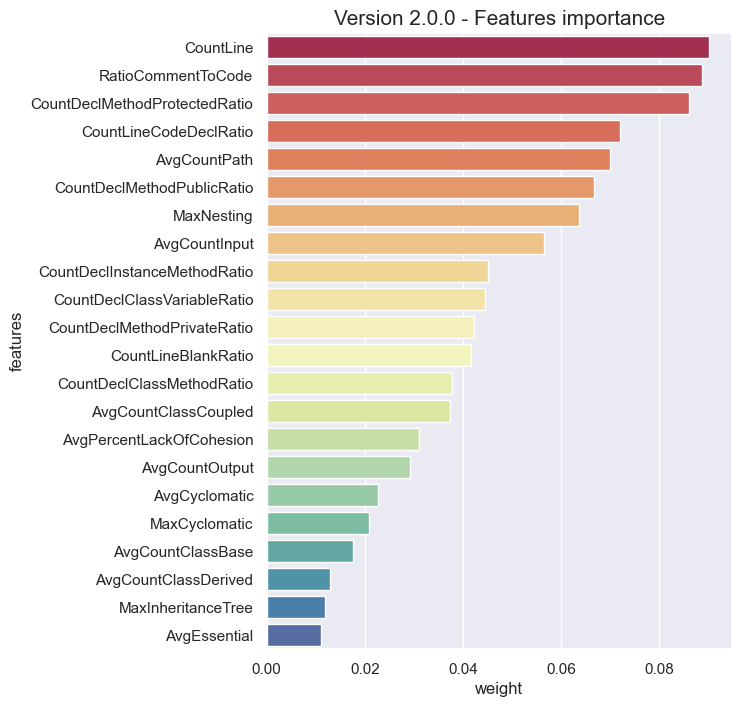

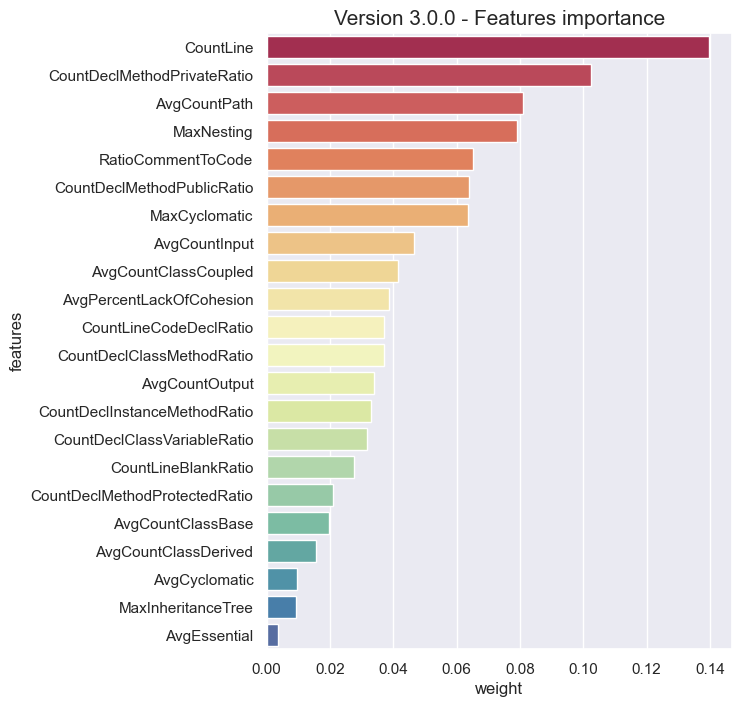

In [13]:
plot_feature_importances(model_2_0_0._final_estimator, "Version 2.0.0", features=X_train.columns)
plot_feature_importances(model_3_0_0._final_estimator, "Version 3.0.0", features=X_train.columns)

The most important feature is ContLine for both models, but we can see some variations in the other features. Before we go any further, lets take a look at the data used to train these model.

In [14]:
def describe_training_set(version):
    ruc = RandomUnderSampler(random_state=1, replacement=True)
    data = df[df["Version"] == version].drop(columns=["File", "Version"])
    X_x = data.drop(columns=["Bug"])
    y = data["Bug"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X_x, y, test_size=.2, random_state=1)
    X_train_resamled, y_train_resampled = ruc.fit_resample(X_train, y_train)
    print("The data used to train the model for {} has a total of {} observations {} of which are bugs.".format(version, len(y_train_resampled), sum(y_train_resampled)))


describe_training_set("2.0.0")
describe_training_set("3.0.0")

The data used to train the model for 2.0.0 has a total of 86 observations 43 of which are bugs.
The data used to train the model for 3.0.0 has a total of 192 observations 96 of which are bugs.


Considering that we have 22 features in our current model, our training set is too small to train a random forest model. It is likly that the feature importance metrics obtained from these models are not reflective of their respective population. It is possible that with a larger sample, the two models will converge.

### Comparing v2.0.0 and v3.0.0 files
To start we create dataframes for each versions.

In [15]:
# Create dataframes for 
data_2_0_0 = df[df["Version"] == "2.0.0"]
data_3_0_0 = df[df["Version"] == "3.0.0"]
data_2_0_0.index = data_2_0_0["File"]
data_3_0_0.index = data_3_0_0["File"]
data_2_0_0 = data_2_0_0.drop(columns=["File", "Version"])
data_3_0_0 = data_3_0_0.drop(columns=["File", "Version"])

data_2_0_0.head()

,AvgCyclomatic,AvgEssential,CountDeclClassMethodRatio,CountDeclClassVariableRatio,CountDeclInstanceMethodRatio,CountDeclMethodPrivateRatio,CountDeclMethodProtectedRatio,CountDeclMethodPublicRatio,CountLine,CountLineBlankRatio,...,AvgCountClassBase,AvgCountClassCoupled,AvgCountClassDerived,MaxInheritanceTree,AvgPercentLackOfCohesion,AvgCountInput,AvgCountOutput,AvgCountPath,MaxNesting,Bug
File,,,,,,,,,,,,,,,,,,,,,
accumulo-handler/src/java/org/apache/hadoop/hive/accumulo/AccumuloConnectionParameters.java,1.0,1.0,0.0,9.0,1.0,0.0,0.000000,0.823529,230.0,0.169565,...,1.0,18.0,1.0,1.0,70.0,6.176471,3.941176,2.058824,2.0,0
accumulo-handler/src/java/org/apache/hadoop/hive/accumulo/AccumuloHiveRow.java,2.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.000000,247.0,0.145749,...,1.5,8.5,0.0,1.0,33.5,6.142857,3.142857,2.666667,3.0,0
accumulo-handler/src/java/org/apache/hadoop/hive/accumulo/AccumuloStorageHandler.java,2.0,1.0,0.0,2.0,1.0,0.0,0.142857,0.857143,408.0,0.132353,...,3.0,53.0,0.0,2.0,90.0,4.476190,4.142857,5.571429,4.0,0
accumulo-handler/src/java/org/apache/hadoop/hive/accumulo/HiveAccumuloHelper.java,2.0,1.0,0.0,17.0,1.0,0.0,0.000000,0.875000,315.0,0.092063,...,1.0,26.0,0.0,1.0,0.0,8.750000,5.750000,2.750000,2.0,0
accumulo-handler/src/java/org/apache/hadoop/hive/accumulo/LazyAccumuloMap.java,2.0,1.0,0.0,0.0,1.0,0.0,0.166667,0.833333,155.0,0.161290,...,1.0,17.0,0.0,4.0,66.0,5.833333,8.500000,4.333333,2.0,0


Lets check the common files between the two versions.

In [16]:
common_files = data_2_0_0.index.intersection(data_3_0_0.index)

print("{:.2f} % of the file in v2.0.0 are also present in v3.0.0".format(common_files.shape[0] / data_2_0_0.shape[0] * 100))
print("{:.2f} % of the file in v3.0.0 are also present in v2.0.0".format(common_files.shape[0] / data_3_0_0.shape[0] * 100))

99.84 % of the file in v2.0.0 are also present in v3.0.0
99.05 % of the file in v3.0.0 are also present in v2.0.0


Now that we know the datasets are very similar, lets check if there's any difference in the features of the files. To do this, we can do a column wise sum of every cell where there is a difference between the two verions.

In [17]:
X_2_0_0 = data_2_0_0.drop(columns=["Bug"])
X_3_0_0 = data_2_0_0.drop(columns=["Bug"])

(X_2_0_0.loc[common_files] != X_3_0_0.loc[common_files]).sum()

AvgCyclomatic                    0
AvgEssential                     0
CountDeclClassMethodRatio        0
CountDeclClassVariableRatio      0
CountDeclInstanceMethodRatio     0
CountDeclMethodPrivateRatio      0
CountDeclMethodProtectedRatio    0
CountDeclMethodPublicRatio       0
CountLine                        0
CountLineBlankRatio              0
CountLineCodeDeclRatio           0
MaxCyclomatic                    0
RatioCommentToCode               0
AvgCountClassBase                0
AvgCountClassCoupled             0
AvgCountClassDerived             0
MaxInheritanceTree               0
AvgPercentLackOfCohesion         0
AvgCountInput                    0
AvgCountOutput                   0
AvgCountPath                     0
MaxNesting                       0
dtype: int64

From this result we can confirm that none of the changes in the files are reflected in our features. Lets check if any of the files reported for bugs in v2.0.0 were reported again in v3.0.0.

In [18]:
y_2_0_0 = data_2_0_0["Bug"]
y_3_0_0 = data_2_0_0["Bug"]

nb_bugs_repeated =  ((y_2_0_0.loc[common_files] + y_3_0_0.loc[common_files]) > 1).sum()
nb_bugs_2_0_0 = (y_2_0_0.loc[common_files] == 1).sum()

print("{} out of {} of the files reported for bugs in v2.0.0 were reported in v3.0.0.".format(nb_bugs_repeated, nb_bugs_2_0_0))
print("This represents {:.2f} % of reported files in v.3.0.0".format( 100* nb_bugs_repeated / data_3_0_0["Bug"].sum()))

50 out of 50 of the files reported for bugs in v2.0.0 were reported in v3.0.0.
This represents 43.10 % of reported files in v.3.0.0


We can conclude from these results that all of the  files reported for bugs in v2.0.0 were reported for bugs in v3.0.0. However, v3.0.0 had more than double the amount of files reported for bugs. This could explain the difference in the features importance across the two versions.